## Disaster Tweets Classification using TinyBERT

# Disaster or General Tweets Classifications

## Download Data

In [2]:

import pandas as pd



In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/master/twitter_disaster_tweets.csv", usecols=['text', 'target'])

df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df.isnull().sum()

df = df.sample(frac=1).reset_index(drop=True)

In [5]:
df['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [6]:
%pip install matplotlib


Note: you may need to restart the kernel to use updated packages.


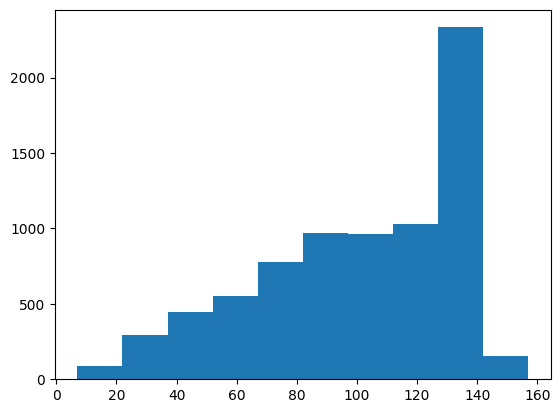

In [7]:
import matplotlib.pyplot as plt
plt.hist(df['text'].str.len())
plt.show()


<Axes: >

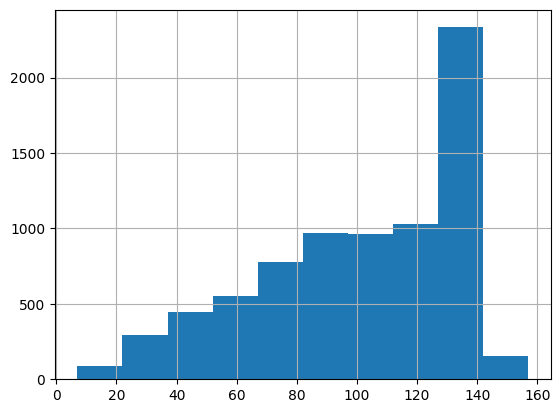

In [8]:
# case, un-cased
# context window -> 512 tokens
# 1 token -> 3char

df['text'].str.len().hist() #-> 160/3 => 53 => 60 tokens




### Load Data with Hugging Face Datasets Library


In [9]:
df = df.rename(columns={'target': 'label'})

In [10]:
%pip install datasets

Note: you may need to restart the kernel to use updated packages.


In [11]:
from datasets import Dataset

dataset = Dataset.from_pandas(df)

dataset = dataset.train_test_split(test_size=0.2)

dataset['train'][0]

/Users/anniii/Desktop/april/sentiment-analysis-Pose-Classification/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'text': 'This thunder is beautiful', 'label': 0}

In [12]:
id2label = {0:'general', 1: 'disaster'}
label2id = {'general': 0, 'disaster': 1}


## Data Tokenization


In [13]:
from transformers import AutoTokenizer
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model_ckpt = 'huawei-noah/TinyBERT_General_4L_312D'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt, use_fast=True)


In [14]:
tokenizer(dataset['train'][0]['text'])

def tokenize(batch):
    temp = tokenizer(batch['text'], padding=True, truncation=True, max_length=100)
    return temp

dataset = dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/6090 [00:00<?, ? examples/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Map: 100%|██████████| 1523/1523 [00:00<00:00, 31405.88 examples/s]


In [15]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6090
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1523
    })
})

## Building Model Evaluation Functions
https://huggingface.co/docs/transformers/v4.42.0/en/tasks/sequence_classification#evaluate

In [16]:
# %pip install evaluate
%pip install scikit-learn


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [17]:


import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

## Model Building


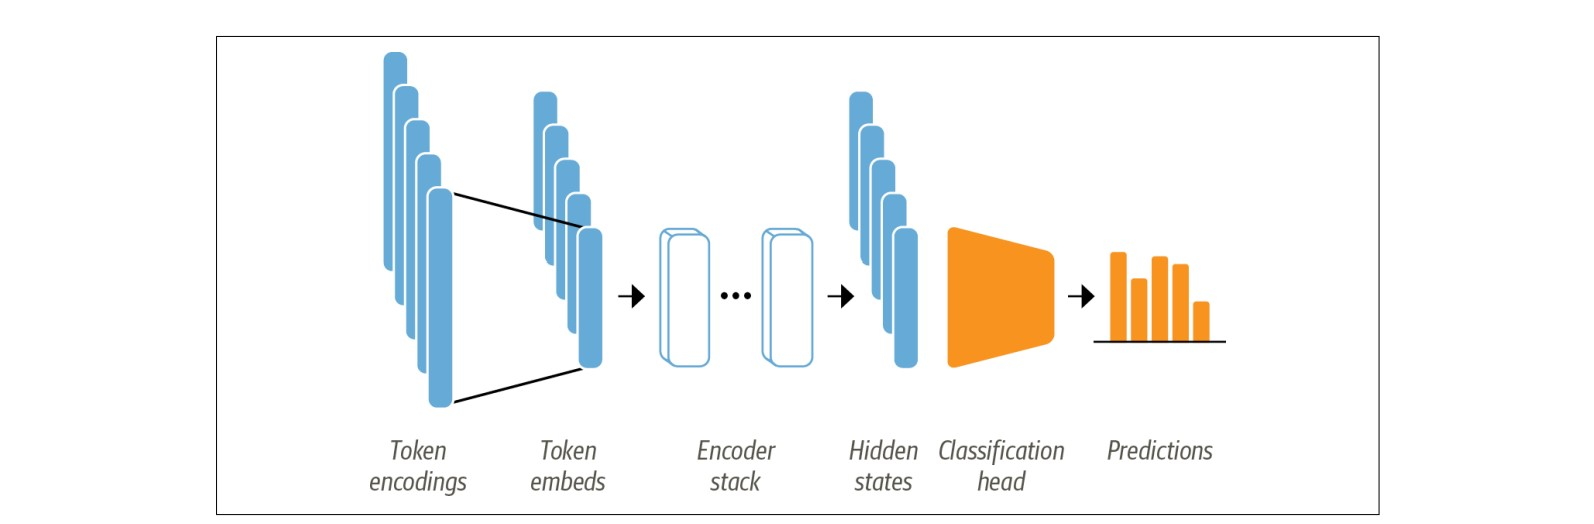

In [18]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=len(label2id), label2id=label2id, id2label=id2label)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
!pip install accelerate -U

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


zsh:1: /Users/anniii/Desktop/april/sentiment-analysis-Pose-Classification/.venv/bin/pip: bad interpreter: /Users/anniii/Downloads/New-Project/08-Deploy_ML_Model_at_Streamlit_Server-main/.venv/bin/python: no such file or directory


In [20]:
args = TrainingArguments(
    output_dir='train_dir',
    overwrite_output_dir=True,
    num_train_epochs=5,
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy='epoch'
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

/Users/anniii/Desktop/april/sentiment-analysis-Pose-Classification/.venv/lib/python3.12/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [21]:
trainer.train()

                                                 
 20%|██        | 192/955 [00:35<14:08,  1.11s/it]

{'eval_loss': 0.48643019795417786, 'eval_accuracy': 0.7984241628365069, 'eval_runtime': 2.4255, 'eval_samples_per_second': 627.912, 'eval_steps_per_second': 19.79, 'epoch': 1.0}


                                                 
 40%|████      | 383/955 [01:03<05:49,  1.64it/s]

{'eval_loss': 0.45608994364738464, 'eval_accuracy': 0.804333552199606, 'eval_runtime': 2.0118, 'eval_samples_per_second': 757.034, 'eval_steps_per_second': 23.859, 'epoch': 2.0}


 52%|█████▏    | 500/955 [01:20<01:01,  7.37it/s]

{'loss': 0.5033, 'grad_norm': 6.568942546844482, 'learning_rate': 4.764397905759163e-06, 'epoch': 2.62}


                                                 
 60%|██████    | 574/955 [01:33<04:43,  1.34it/s]

{'eval_loss': 0.45755231380462646, 'eval_accuracy': 0.8030203545633617, 'eval_runtime': 1.9355, 'eval_samples_per_second': 786.864, 'eval_steps_per_second': 24.799, 'epoch': 3.0}


                                                 
 80%|████████  | 765/955 [02:02<02:26,  1.29it/s]

{'eval_loss': 0.4481692612171173, 'eval_accuracy': 0.8056467498358503, 'eval_runtime': 1.9776, 'eval_samples_per_second': 770.124, 'eval_steps_per_second': 24.272, 'epoch': 4.0}


                                                 
100%|██████████| 955/955 [02:31<00:00,  6.28it/s]

{'eval_loss': 0.45029711723327637, 'eval_accuracy': 0.8049901510177282, 'eval_runtime': 1.8836, 'eval_samples_per_second': 808.562, 'eval_steps_per_second': 25.483, 'epoch': 5.0}
{'train_runtime': 151.9715, 'train_samples_per_second': 200.366, 'train_steps_per_second': 6.284, 'train_loss': 0.4591483390768161, 'epoch': 5.0}


TrainOutput(global_step=955, training_loss=0.4591483390768161, metrics={'train_runtime': 151.9715, 'train_samples_per_second': 200.366, 'train_steps_per_second': 6.284, 'total_flos': 71633368245600.0, 'train_loss': 0.4591483390768161, 'epoch': 5.0})

In [22]:
trainer.evaluate()

100%|██████████| 48/48 [00:01<00:00, 27.06it/s]


{'eval_loss': 0.45029711723327637,
 'eval_accuracy': 0.8049901510177282,
 'eval_runtime': 2.0915,
 'eval_samples_per_second': 728.198,
 'eval_steps_per_second': 22.95,
 'epoch': 5.0}

## Model Save and Load for Inference


In [23]:
trainer.save_model('tinybert-disaster-tweet')

In [26]:
from transformers import pipeline
import torch

# data = ['this movie was horrible, the plot was really boring. acting was okay',
#         'the movie is really sucked. there is not plot and acting was bad',
#         'what a beautiful movie. great plot. acting was good. will see it again']

data = ['There is a fire in the building', 'I am happy today', 'I am sad today', 
          'I am not feeling well','There is a flood in the city, go to higher ground']

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

classifier = pipeline('text-classification', model='/Users/anniii/Desktop/april/sentiment-analysis-Pose-Classification/tinybert-disaster-tweet', device=device)

classifier(data)

[{'label': 'disaster', 'score': 0.8642094731330872},
 {'label': 'general', 'score': 0.8858670592308044},
 {'label': 'general', 'score': 0.8719755411148071},
 {'label': 'general', 'score': 0.8832300305366516},
 {'label': 'disaster', 'score': 0.8802012205123901}]

## Push Model to AWS S3

In [38]:
# upload model folder to s3 bucket ml-models/tinybert-sentiment-analysis
import os
import boto3

s3 = boto3.client('s3')
bucket_name = 'mlops-kgptalkie'

def upload_directory(directory_path, s3_prefix):
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            file_path = os.path.join(root, file).replace("\\", "/")
            relpath = os.path.relpath(file_path, directory_path)
            s3_key = os.path.join(s3_prefix, relpath).replace("\\", "/")
            
            s3.upload_file(file_path, bucket_name, s3_key)


upload_directory('tinybert-disaster-tweet', 'ml-models/tinybert-disaster-tweet')